# Examples of an AE + VAE

Example of VAE and AE on MNIST dataset using a CNN.
There are three models the encoder, decoder and autoencoder.
The encoder generates the latent variables and the 
decoder can be used to generate MNIST digits by sampling. The VAE
restricts the latent vector/variable to be from a Gaussian distribution 
with mean = 0 and std = 1.

## AE Example

- Here the xample uses Convolutional and MaxPooling layers in the enocder.
- Uses Convolutional Transpose and UpSampling layers in the decoder.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Load the module we need
# Note that we are import the Keras backend, which is assumed to be Tensorflow
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers import Layer, UpSampling2D, Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adagrad
#from tensorflow.keras import backend as K

from keras.datasets import mnist
import numpy as np

import matplotlib.pyplot as plt



from keras.layers import Lambda
from keras.losses import MeanSquaredError, binary_crossentropy, KLDivergence
from keras.utils import plot_model

import tensorflow as tf
import os

In [4]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent subspace
    if (model_name == 'vae_mlp'):
        z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    else:
        z_mean = encoder.predict(x_test,batch_size=batch_size)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(np.amin(z_mean[:,0]), np.amax(z_mean[:,0]), n)
    grid_y = np.linspace(np.amin(z_mean[:,1]), np.amax(z_mean[:,1]), n)[::-1]

    z_sample = np.zeros((1,5))
    z_sample[0,2] = np.mean(z_mean[:,2])
    z_sample[0,3] = np.mean(z_mean[:,3])
    z_sample[0,4] = np.mean(z_mean[:,4])    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample[0,0] = xi
            z_sample[0,1] = yi
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [5]:
# Load MNIST datasets (training and test)
batch_size = 128
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
# Define the Encoder, inputs are the MNIST 28x28 greyscale images 
input_img = Input(shape=(28, 28, 1),batch_size=batch_size)  


x = Conv2D(32, (3, 3), activation='relu',padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = Reshape((128,))(x)
z = Dense(5,activation='linear')(x)    

encoded = Model(input_img,z,name='encoded')
encoded.summary()
plot_model(encoded, to_file='AE_encoded.png', show_shapes=True)            

# Latent space is a 5 dimensional vector space

# This is the decoder, it take the 5 dim latent vector and generates a 28x28 image
lats = Input(shape=(5,),name='latent')
x = Dense(128,activation='relu')(lats)
x = Reshape((4,4,8))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
rec = Conv2DTranspose(1, (3, 3), activation='relu',padding="same")(x)

decoded = Model(lats,rec,name='decoded')
decoded.summary()
plot_model(decoded, to_file='AE_decoded.png', show_shapes=True)     

# The autoencoder takes the image as input encodes it, then decodes it
rec = decoded(encoded(input_img))
autoencoder = Model(input_img,rec)

# import tensorflow as tf

class ReconLoss(tf.keras.losses.Loss):
    def __init__(self, name="ReconstructionLoss", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):

        loss = tf.reduce_sum(tf.math.square(y_true - y_pred),axis=(1,2))
        return tf.math.reduce_mean(loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

loss=ReconLoss()

autoencoder.compile(optimizer='adadelta',loss=loss)
autoencoder.summary()

Model: "encoded"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (128, 28, 28, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (128, 28, 28, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (128, 14, 14, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (128, 12, 12, 16)      │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (128, 6, 6, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (128, 4, 4, 8)         │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (128, 128)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 5)               │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,749 (26.36 KB)

 Trainable params: 6,749 (26.36 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "decoded"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent (InputLayer)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 6, 6, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,865 (26.82 KB)

 Trainable params: 6,865 (26.82 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (128, 28, 28, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Functional)            │ (128, 5)               │         6,749 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Functional)            │ (128, 28, 28, 1)       │         6,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,614 (53.18 KB)

 Trainable params: 13,614 (53.18 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model, this can take some time
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 82.5880 - val_loss: 58.1708
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 52.0618 - val_loss: 49.6958
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 48.4123 - val_loss: 47.3243
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 46.5024 - val_loss: 45.8483
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 45.4246 - val_loss: 45.0612
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 44.8213 - val_loss: 44.5747
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 44.4237 - val_loss: 44.2288
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 44.1226 - val_loss: 43.9470
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 43.8696 - val_loss: 43.7031
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 43.6450 - val_loss: 43.4793


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


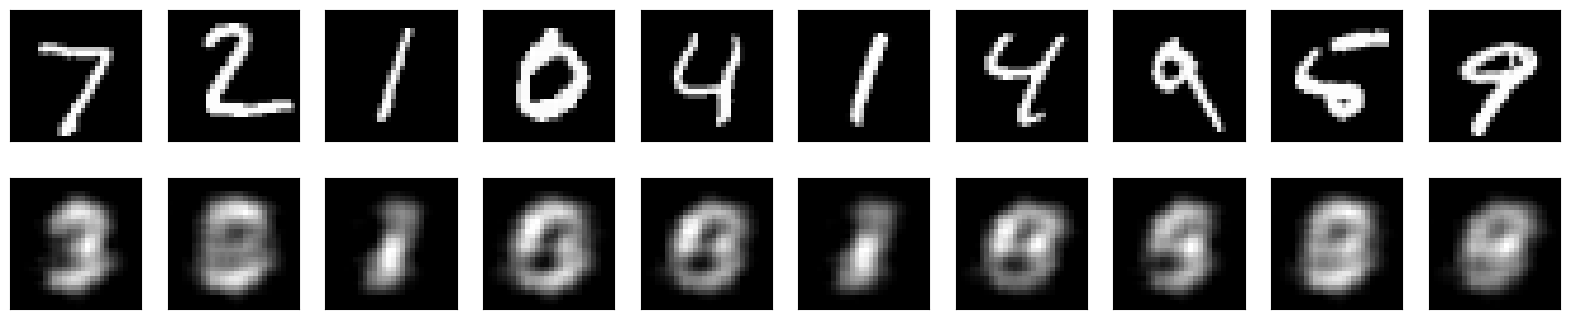

In [9]:
# Show a sample of test images that have been through the autoencoder
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


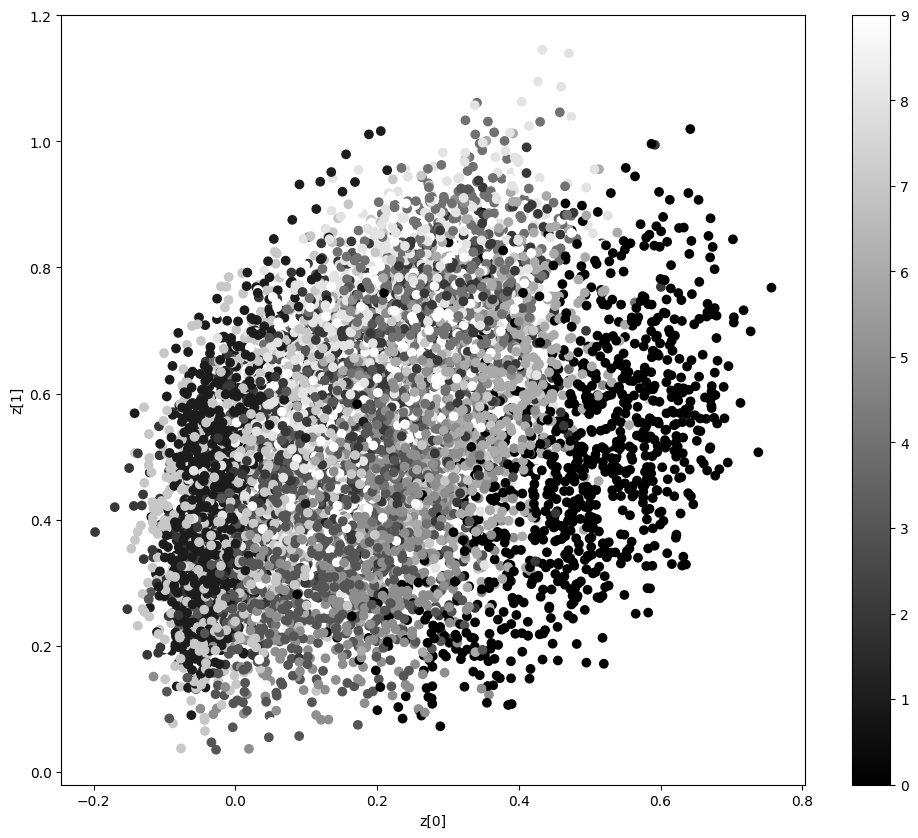

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

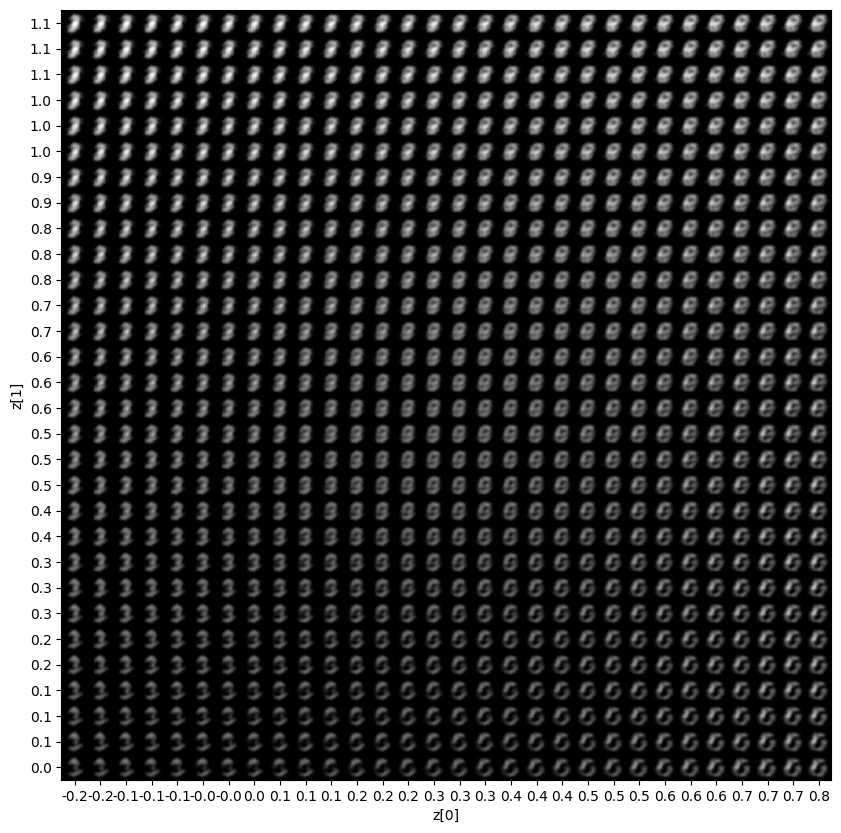

In [10]:
# Use the plot_results function to show a latent subspace 
# Use a grid of latent variables to generate MNIST images
batch_size=128
plot_results((encoded,decoded),
            (x_test,y_test),
                 batch_size=batch_size,
                 model_name="AE")

## VAE

- Here is an example of a Variational AutoEncoder.
- The example wa changed extensively from gthe original, due to updates in tensorflow. 
- [The examnple followed cae from this link.](https://www.tensorflow.org/tutorials/generative/cvae)

In [11]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            Conv2D(
                filters=32, kernel_size=3, strides=(1, 1), activation='relu', padding='same'),
            MaxPooling2D(pool_size=2),
            Conv2D(
                filters=16, kernel_size=3, strides=(1, 1), activation='relu'),
            MaxPooling2D(pool_size=2),
            Conv2D(
                filters=8, kernel_size=3, strides=(1, 1), activation='relu'),
            Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4, 4, 8)),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=3, strides=1, activation='relu'),
            UpSampling2D(size=2),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=1, activation='relu'),
            UpSampling2D(size=2),            
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z):
    logits = self.decoder(z)
    return logits

optimizer = tf.keras.optimizers.Adam(1e-4)


def KLnorm(mean, logvar, raxis=1):
  return -0.5*tf.reduce_sum(
        (1.0 + logvar - mean**2 - tf.math.exp(logvar)),
        axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_pred = model.decode(z)
  recon = tf.math.square(x - x_pred)
  rec_loss = tf.reduce_sum(recon, axis=[1, 2, 3])
  kldiv = KLnorm(mean, logvar)
  return tf.reduce_mean(rec_loss + kldiv)

def compute_kldiv(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  kldiv = KLnorm(mean, logvar)
  return tf.reduce_mean(kldiv)

def compute_recon(model,x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_pred = model.decode(z)
  recon = tf.math.square(x - x_pred)
  rec_loss = tf.reduce_sum(recon, axis=[1, 2, 3])
  return tf.reduce_mean(rec_loss)

def predict(model,x):
  mean, logvar = model.encode(x)
  x_pred = model.decode(mean)
  return x_pred


#@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
    
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
      loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [12]:
epochs = 5
train_size=60000
test_size=10000
batch_size = 128
latent_dim = 5

train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

vae = CVAE(latent_dim)

vae.encoder.summary()
vae.decoder.summary()

c:\Users\ppodder\MS_AI\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,394 (28.88 KB)

 Trainable params: 7,394 (28.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 6, 6, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,865 (26.82 KB)

 Trainable params: 6,865 (26.82 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
for epoch in range(1, epochs + 1):
# Train over batches
  for train_x in train_dataset:
    train_step(vae, train_x, optimizer)

# Training loss at epoch
  train_loss = 0
  train_rec = 0
  train_kl = 0
  for train_x in train_dataset:
    train_loss = train_loss + compute_loss(vae, train_x)
    train_rec = train_rec + compute_recon(vae, train_x)
    train_kl = compute_kldiv(vae, train_x)
  train_loss = batch_size*train_loss/train_size
  train_rec = batch_size*train_rec/train_size
  train_kl = batch_size*train_kl/train_size

# Test loss at epoch
  test_loss = 0
  for test_x in test_dataset:
    test_loss = test_loss + compute_loss(vae, test_x)
    test_kl = compute_kldiv(vae, test_x)
  test_loss = batch_size*test_loss/test_size
  print('Epoch: {}, Training loss: {}, Test loss: {}, Train Recon: {}, Train KL_div: {}'
        .format(epoch,train_loss,test_loss,train_rec,train_kl))

Epoch: 1, Training loss: 53.355228424072266, Test loss: 54.003231048583984, Train Recon: 50.56922912597656, Train KL_div: 0.005461996886879206
Epoch: 2, Training loss: 45.2879638671875, Test loss: 45.53301239013672, Train Recon: 40.12949752807617, Train KL_div: 0.010925134643912315
Epoch: 3, Training loss: 42.6810302734375, Test loss: 42.85661697387695, Train Recon: 37.11878204345703, Train KL_div: 0.011759399436414242
Epoch: 4, Training loss: 41.21760940551758, Test loss: 41.37520980834961, Train Recon: 35.525203704833984, Train KL_div: 0.012334656901657581
Epoch: 5, Training loss: 40.21381378173828, Test loss: 40.3521614074707, Train Recon: 34.417938232421875, Train KL_div: 0.012558849528431892


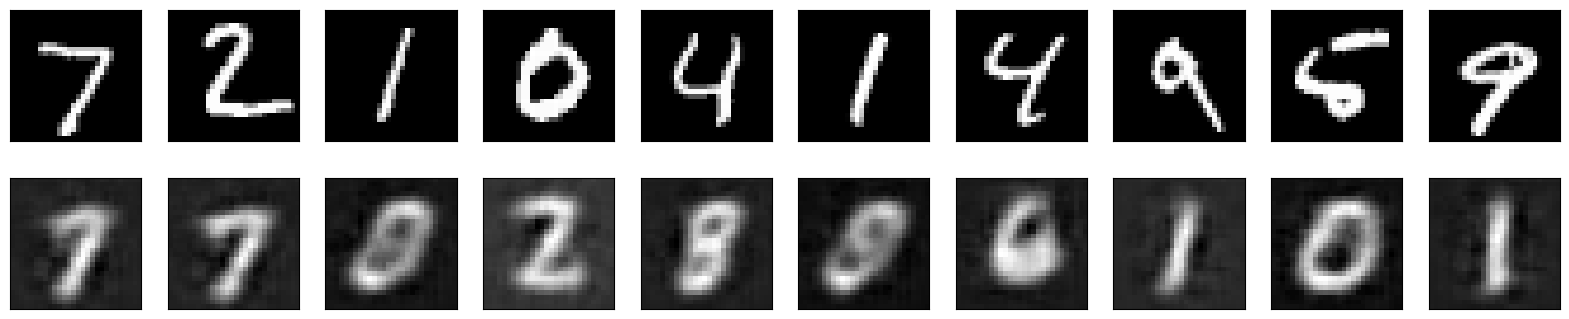

In [14]:
# Show some reconstruction examples from the test set

for train_x in train_dataset.take(batch_size):
    decoded_imgs = predict(vae,train_x).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Plot the latent subspace and generate MNIST images from a grid in latent space
#plot_results((encoder,decoder),
#            (x_test,y_test),
#                 batch_size=batch_size,
#                 model_name="vae_mlp")